In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pygsp
import scipy 

from helper.helper_plot import *

plt.rcParams['image.cmap'] = "turbo"

## 6. Graph Wavelet Transform

### 6.1. Spectral Graph Wavelets

Given a bandpass filter $g(u)$, a wavelet centered on node $i$ at scale $s\geq 0$:

$$
\varphi_{s,i} = U g(s\Lambda) U^T \delta_i \in \mathbb{R}^N
$$

where $\delta_i \in \mathbb{R}^N$ is the Dirac centered on node $i$.

### 6.2. Spectral Graph Wavelet Coefficients

Given a graph signal $x$, the wavelet coefficient at node $i$ and scale $s$, denoted by $W_{s,i}(x)$ is the projection of the signal on $\varphi_{s,i}$:

$$
W_{s,i}(x) = \varphi_{s,i}^T x \in \mathbb{R}
$$

### 6.3. Wavelet Filterbanks

Let us consider $\mathcal{S}=(s_1,...,s_m)$ a set of $m$ scales. The collection of $m$ filters $\{g(s_1u),...,g(s_mu)\}$ is called a **filterbank**.

**Q:** Consider all wavelet coefficients $\{W_{s,i}\}$ of a graph signal $x$, can we reconstruct perfectly $x$ from its wavelet coefficients?<br>
**A:** No!

Let us add a low-pass $h(u)$ to the filterbank: $h(u) = e^{-u}$. 

**Q:** Do the coefficients extracted from the combination of filters $(h(u), g(s_1u),...,g(s_mu))$ enough for perfect reconstruction of any $\mathbb{R}^N signal$?<br>
**A**: Yes, iff

$$
\min_{u \in \{\lambda_0,...,\lambda_{N-1}\}} h^2(u) + \sum_{s \in \mathcal{S}} g^2(su) > 0
$$

In [33]:
G = pygsp.graphs.Sensor(seed=42)
G.compute_fourier_basis()

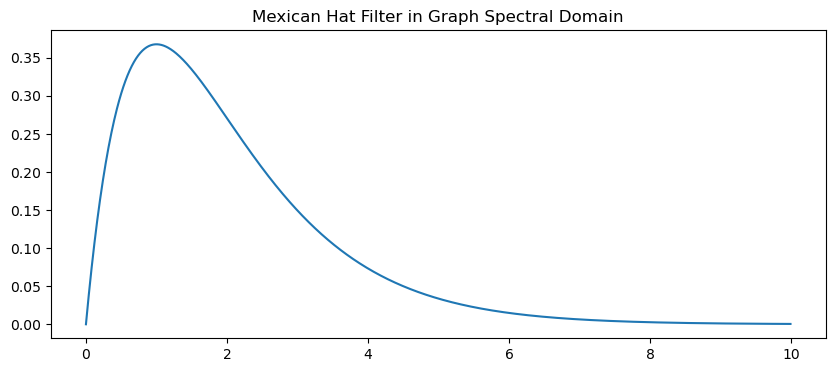

In [41]:
mex_hat = lambda x : x * np.exp(-x)
plt.figure(figsize=(10,4))
plt.plot(np.arange(0,10,0.01), mex_hat(np.arange(0,10,0.01)))
plt.title("Mexican Hat Filter in Graph Spectral Domain")
plt.show()

In [42]:
m = 5
g = pygsp.filters.MexicanHat(G, Nf = m+1, lpfactor = 50)

In [43]:
eval_x = np.arange(0, G.lmax, G.lmax/1000)
y = g.evaluate(eval_x)

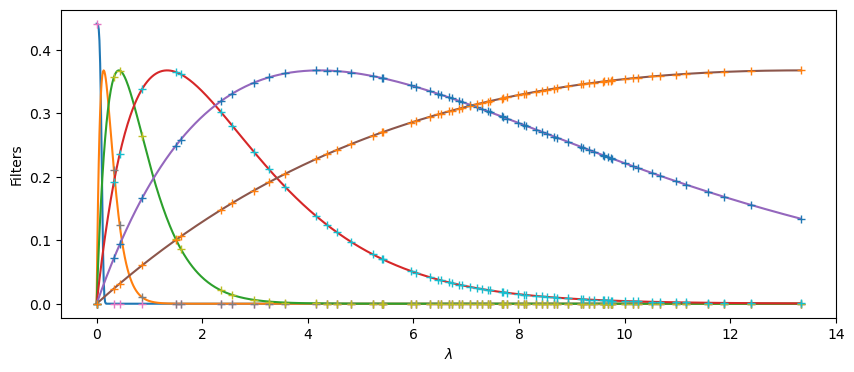

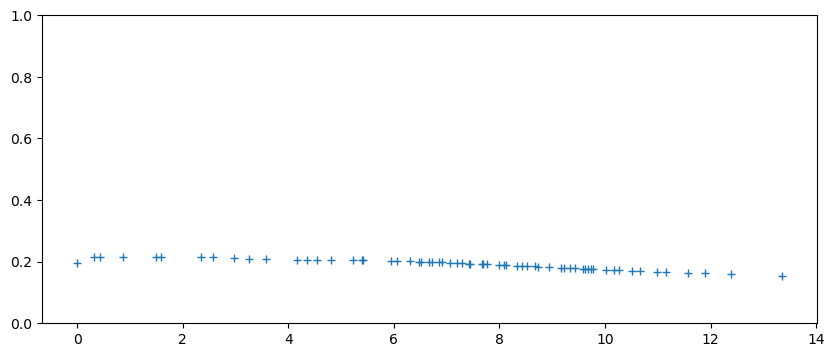

=> Perfect reconstruction is possible. But the frame is not tight tough.


In [44]:
plt.figure(figsize=(10,4))
plt.plot(eval_x, y.T)
plt.plot(G.e, g.evaluate(G.e).T, '+')
plt.ylabel("Filters")
plt.xlabel("$\lambda$")
plt.show()
plt.figure(figsize=(10,4))
plt.plot(G.e, np.sum(np.power(g.evaluate(G.e).T,2),1), '+')
plt.ylim([0, 1])
plt.show()

print("=> Perfect reconstruction is possible. But the frame is not tight tough.")

In [45]:
node = 10
delta_node = np.zeros((G.N,))
delta_node[node] = 1
wavelet_at_node = g.filter(delta_node)
print(wavelet_at_node.shape, " =  (G.N, Nf)")

(64, 6)  =  (G.N, Nf)


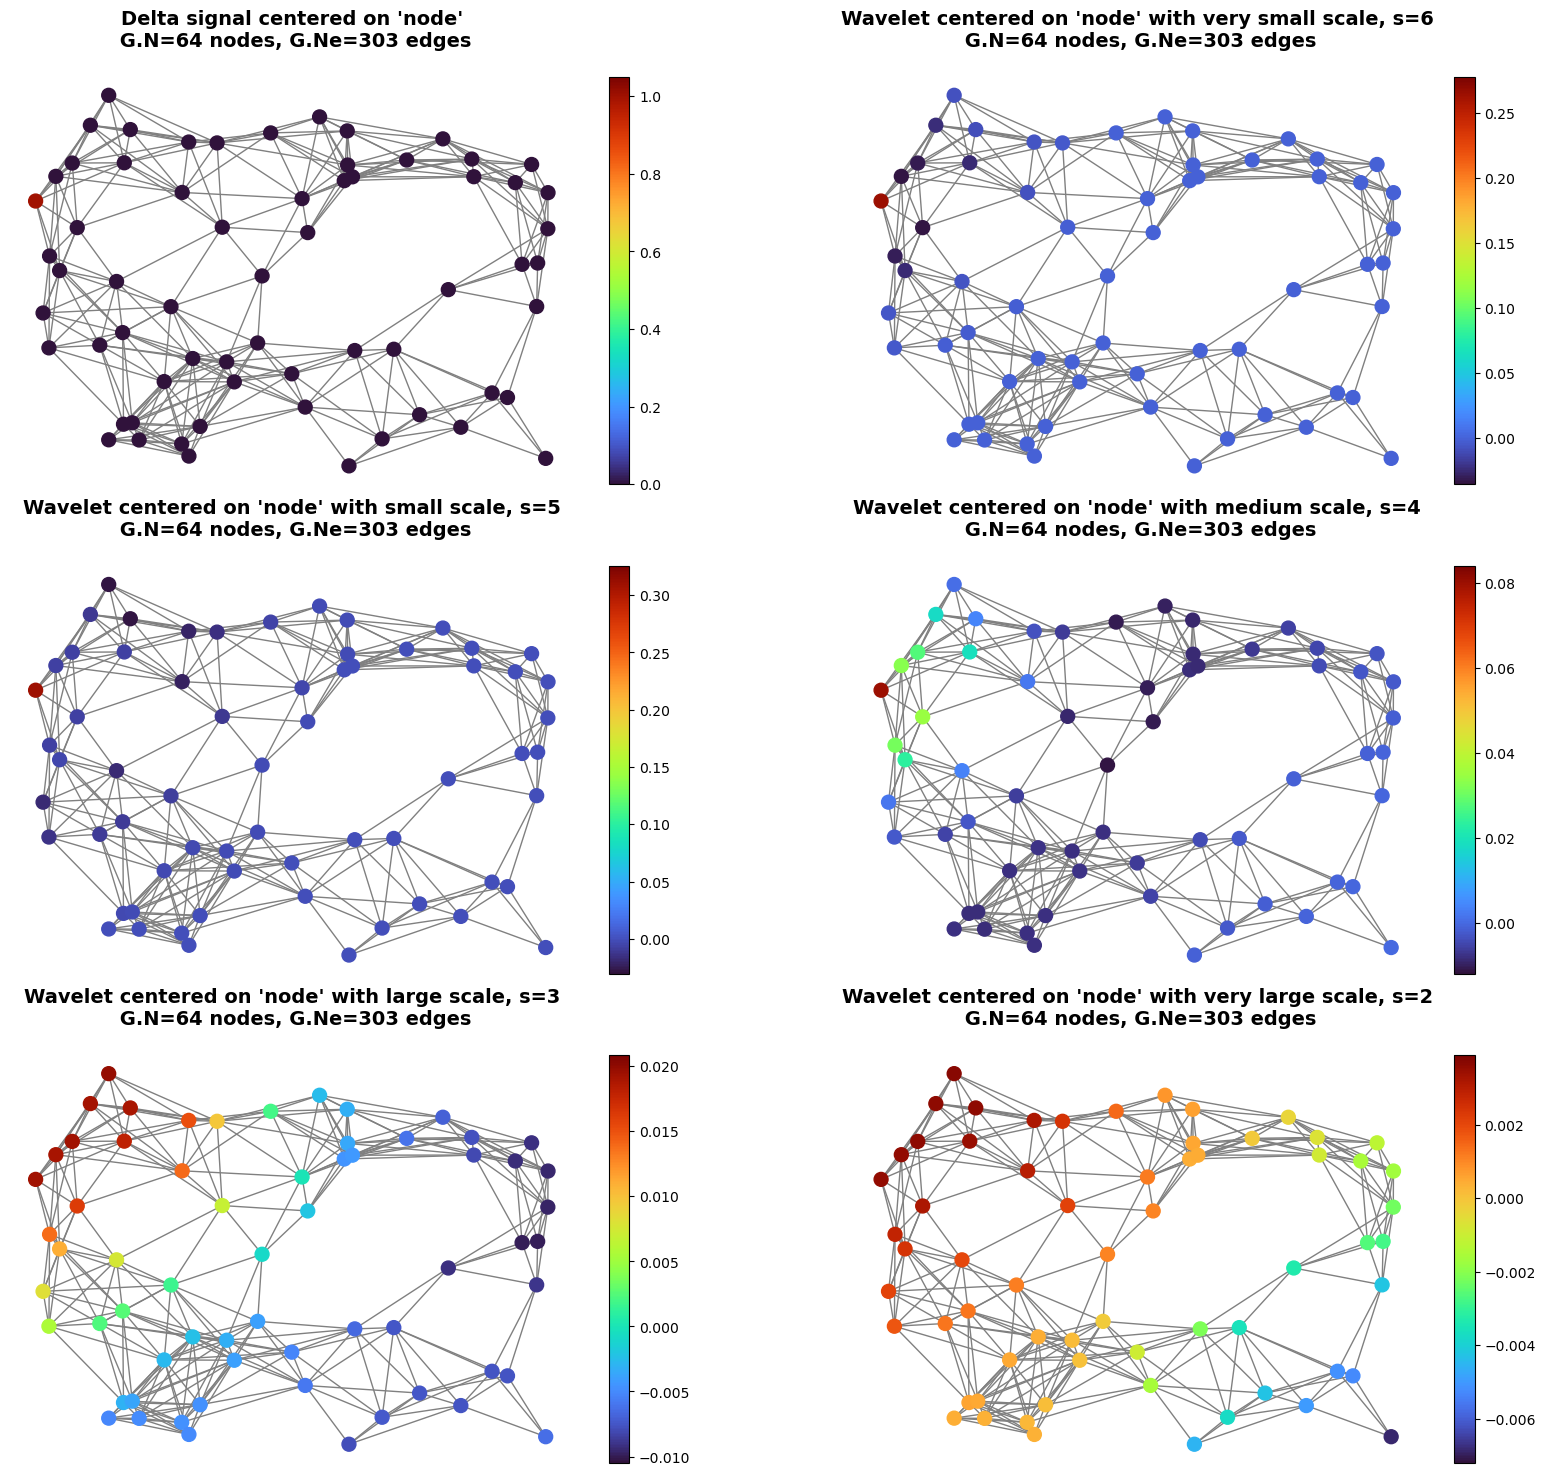

In [48]:
fig, axes = plt.subplots(3,2,figsize=(20,18))
myGraphPlotSignal(G, 
                s = delta_node,
                title = "Delta signal centered on 'node'",
                ax = axes[0,0])
myGraphPlotSignal(G, 
                s = wavelet_at_node[:,5],
                title = "Wavelet centered on 'node' with very small scale, s=6",
                ax = axes[0,1])
myGraphPlotSignal(G, 
                s = wavelet_at_node[:,4],
                title = "Wavelet centered on 'node' with small scale, s=5",
                ax = axes[1,0])
myGraphPlotSignal(G, 
                s = wavelet_at_node[:,3],
                title = "Wavelet centered on 'node' with medium scale, s=4",
                ax = axes[1,1])
myGraphPlotSignal(G, 
                s = wavelet_at_node[:,2],
                title = "Wavelet centered on 'node' with large scale, s=3",
                ax = axes[2,0])
myGraphPlotSignal(G, 
                s = wavelet_at_node[:,1],
                title = "Wavelet centered on 'node' with very large scale, s=2",
                ax = axes[2,1])


### 6.4. Application: Compression


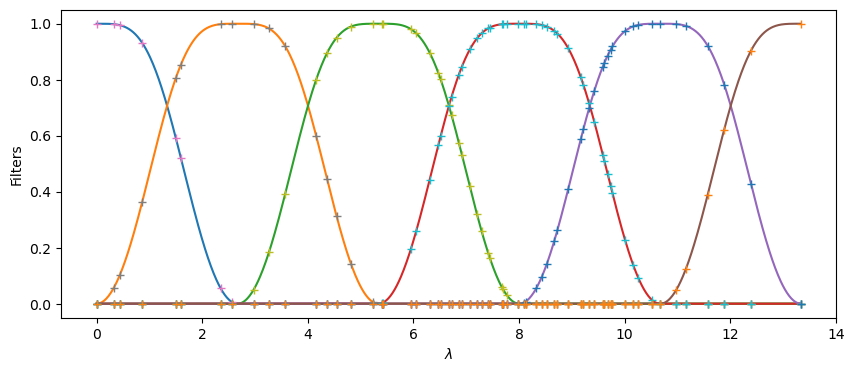

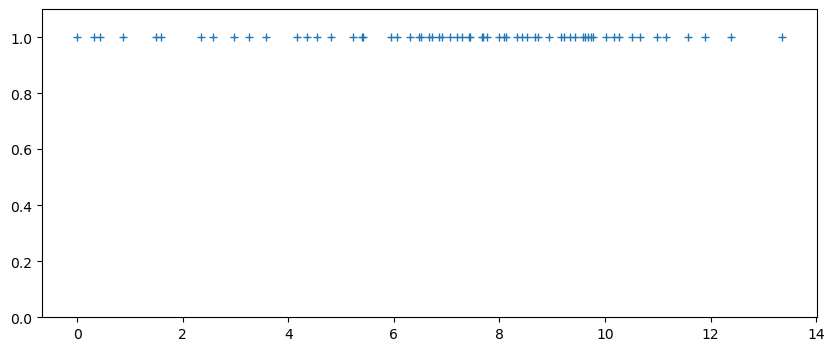

=> Perfect reconstruction is possible and the frame is tight.


In [50]:
m = 5
g = pygsp.filters.Itersine(G, Nf = m+1)

eval_x = np.arange(0, G.lmax, G.lmax/1000)
y = g.evaluate(eval_x)

plt.figure(figsize=(10,4))
plt.plot(eval_x, y.T)
plt.plot(G.e, g.evaluate(G.e).T, '+')
plt.ylabel("Filters")
plt.xlabel("$\lambda$")
plt.show()
plt.figure(figsize=(10,4))
plt.plot(G.e, np.sum(np.power(g.evaluate(G.e).T,2),1), '+')
plt.ylim([0, 1.1])
plt.show()

print("=> Perfect reconstruction is possible and the frame is tight.")

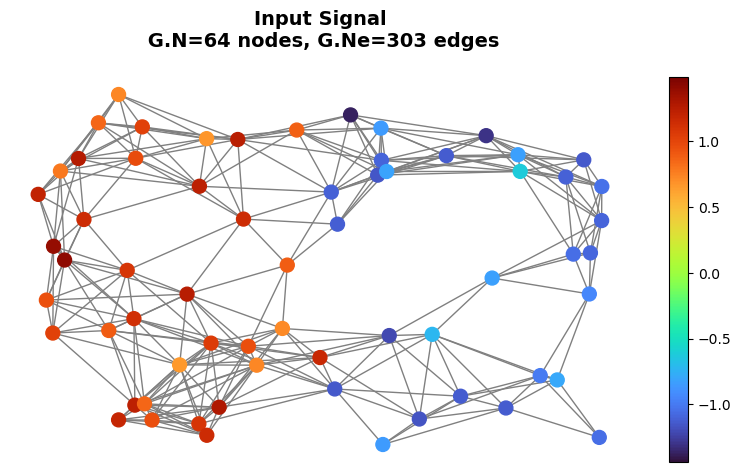

In [51]:
comp_level = 0.9

x_toy_orig = -np.ones((G.N,))
ind_left = G.coords[:,0] < 0.5
x_toy_orig[ind_left] = 1
x_toy_noisy = x_toy_orig + 0.2 * np.random.randn(G.N)

myGraphPlotSignal(G, 
                s = x_toy_noisy,
                title = "Input Signal")

In [54]:
W_coeffs = g.filter(x_toy_noisy, method='exact')
n_coef = np.prod(W_coeffs.shape)
n_coef_comp = np.ceil((1 - comp_level) * n_coef).astype(int)

sorted_coefs = np.sort(np.abs(W_coeffs), axis=None)
threshold = sorted_coefs[-n_coef_comp]

W_coeffs_th = W_coeffs.copy()
W_coeffs_th[np.abs(W_coeffs) < threshold] = 0

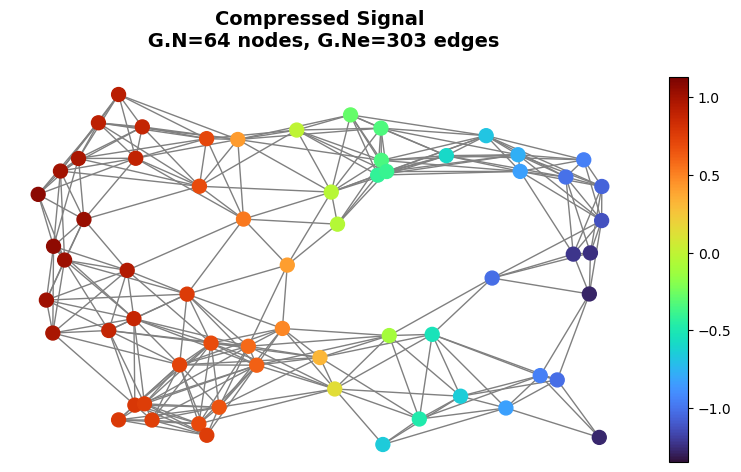

Error Norm:  3.917070447806498


In [56]:
x_toy_recovered = g.synthesize(W_coeffs_th, method='exact')
myGraphPlotSignal(G, 
                s = x_toy_recovered,
                title = "Compressed Signal")
print("Error Norm: " str(np.linalg.norm(x_toy_recovered-x_toy_noisy)))


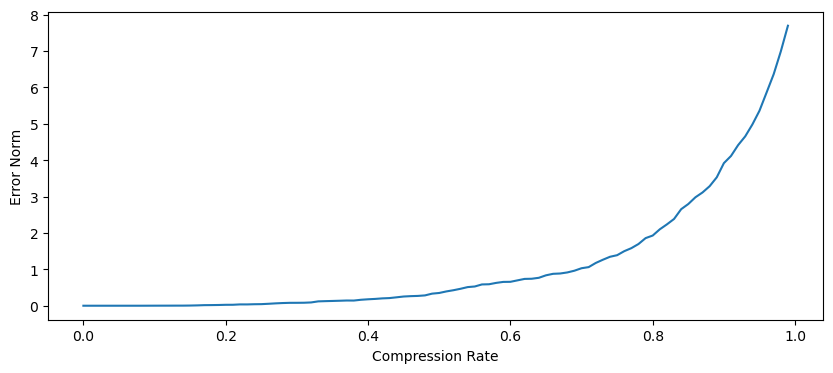

In [59]:
comp_levels = np.arange(0,1,0.01)

err_norms = []

for c in comp_levels:
    
    n_coef_comp = np.ceil((1 - c) * n_coef).astype(int)

    threshold = sorted_coefs[-n_coef_comp]

    W_coeffs_th = W_coeffs.copy()
    W_coeffs_th[np.abs(W_coeffs) < threshold] = 0

    x_toy_recovered = g.synthesize(W_coeffs_th, method='exact')

    err_norms.append(np.linalg.norm(x_toy_recovered-x_toy_noisy))
    
plt.figure(figsize=(10,4))
plt.plot(comp_levels, err_norms)
plt.xlabel("Compression Rate")
plt.ylabel("Error Norm")
plt.show()